In [164]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

def normalisation(X):
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)

class CustomDataset(Dataset):
    def __init__(self, clean_data, noisy_data):
        self.clean = clean_data
        self.noisy = noisy_data

    def __len__(self):
        return len(self.clean)

    def __getitem__(self, index):
        clean = normalisation(self.clean[index, :])
        dirty = normalisation(self.noisy[index, :])

        clean_tensor = torch.from_numpy(clean)
        noisy_tensor = torch.from_numpy(dirty)

        clean_tensor = clean_tensor.view(1, -1).type(torch.FloatTensor)
        noisy_tensor = noisy_tensor.view(1, -1).type(torch.FloatTensor)

        return clean_tensor, noisy_tensor

In [165]:
class config:
    batch_size=10
    learning_rate=1e-3
    epochs=50

In [166]:
clean = pd.read_csv('label3f.csv').to_numpy()
noisy = pd.read_csv('train3f.csv').to_numpy()

test_clean = clean[:10]
test_noisy = noisy[:10]

training_dataset = CustomDataset(clean[10:900], noisy[10:900])
validation_dataset = CustomDataset(clean[900:990], noisy[900:990])
test_dataset = CustomDataset(clean[:10], noisy[:10])

trainloader = DataLoader(training_dataset, batch_size=config.batch_size)
validloader = DataLoader(validation_dataset, batch_size=config.batch_size)
testloader = DataLoader(test_dataset, batch_size=1)

In [167]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

        self.encoder2 = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),

        )

        self.decoder2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 4096),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [168]:
from torchsummary import summary

model = AE()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

summary(model, (1, 4096))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 128, 4096]             512
              ReLU-2            [-1, 128, 4096]               0
         MaxPool1d-3            [-1, 128, 2048]               0
            Conv1d-4             [-1, 64, 2048]          24,640
              ReLU-5             [-1, 64, 2048]               0
         MaxPool1d-6             [-1, 64, 1024]               0
            Conv1d-7             [-1, 32, 1024]           6,176
              ReLU-8             [-1, 32, 1024]               0
         MaxPool1d-9              [-1, 32, 512]               0
           Conv1d-10              [-1, 16, 512]           1,552
             ReLU-11              [-1, 16, 512]               0
  ConvTranspose1d-12             [-1, 32, 1024]           1,568
             ReLU-13             [-1, 32, 1024]               0
  ConvTranspose1d-14             [-1, 6

In [169]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def trainA(dataloader, model, epoch, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    for i, (clean, noisy) in enumerate(tqdm(dataloader)):
        clean = clean.to(device)
        noisy = noisy.to(device)

        optimizer.zero_grad()
        pred = model(noisy)
        curr_loss = loss_fn(pred, clean)
        curr_loss.backward()
        optimizer.step()

        # total_loss += curr_loss
        # if (i+1) % 40 == 0:
        #     print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, total_loss/(i+1)))

    print('[Epoch number : %d] loss: %.3f' % (epoch + 1, total_loss/89))

def valA(dataloader, model, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    print('-------------------------')
    with torch.no_grad():
        for i, (clean, noisy) in enumerate(tqdm(dataloader)):
            clean = clean.to(device)
            noisy = noisy.to(device)

            output = model(noisy)
            loss = loss_fn(output, clean)
            total_loss += loss

            pred1D = output.cpu().detach().numpy().reshape(10, 4096)
            clean1D= clean.cpu().detach().numpy().reshape(10, 4096)

            if i%4 == 0:
                plt.figure()
                plt.plot(np.arange(0, 4096, 1), pred1D[1])
                plt.plot(np.arange(0, 4096, 1), clean1D[1])
                plt.xlim([0, 200])
                plt.show()

        print('[Validation] loss: %.3f' %
              (total_loss / 90))

In [170]:
for clean, dirty in trainloader:
    image_test = dirty
    image_clean = clean

In [171]:
from torch import optim

%matplotlib qt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = AE().to(device)

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
loss_fn = torch.nn.functional.mse_loss

image_test = []
image_clean = []
for clean, dirty in testloader:
    image_test = dirty
    image_clean = clean

image_clean = image_clean.detach().cpu().numpy()
image_clean = image_clean.reshape(-1,)

image_test = image_test.to(device)

for epoch in range(config.epochs):
    print("-------------------| EPOCH %d |-------------------" % epoch)
    trainA(trainloader, model, epoch, loss_fn, optimizer, device)
    # valA(validloader, model, epoch, loss_fn, device)
    print("--------------------------------------------------")

    image_res = model(image_test)
    image_res = image_res.detach().cpu().numpy()
    image_res = image_res.reshape(-1,)



    plt.clf()
    plt.plot(image_clean[:100])
    plt.plot(image_res[:100])
    plt.pause(0.01)

%matplotlib inline

-------------------| EPOCH 0 |-------------------


100%|██████████| 89/89 [00:00<00:00, 90.03it/s] 


[Epoch number : 1] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 1 |-------------------


100%|██████████| 89/89 [00:00<00:00, 113.15it/s]


[Epoch number : 2] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 2 |-------------------


100%|██████████| 89/89 [00:00<00:00, 113.29it/s]


[Epoch number : 3] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 3 |-------------------


100%|██████████| 89/89 [00:00<00:00, 118.25it/s]


[Epoch number : 4] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 4 |-------------------


100%|██████████| 89/89 [00:00<00:00, 113.40it/s]


[Epoch number : 5] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 5 |-------------------


100%|██████████| 89/89 [00:00<00:00, 122.30it/s]


[Epoch number : 6] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 6 |-------------------


100%|██████████| 89/89 [00:00<00:00, 125.60it/s]


[Epoch number : 7] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 7 |-------------------


100%|██████████| 89/89 [00:00<00:00, 122.79it/s]


[Epoch number : 8] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 8 |-------------------


100%|██████████| 89/89 [00:00<00:00, 122.09it/s]


[Epoch number : 9] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 9 |-------------------


100%|██████████| 89/89 [00:00<00:00, 117.17it/s]


[Epoch number : 10] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 10 |-------------------


100%|██████████| 89/89 [00:00<00:00, 124.59it/s]


[Epoch number : 11] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 11 |-------------------


100%|██████████| 89/89 [00:00<00:00, 123.39it/s]


[Epoch number : 12] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 12 |-------------------


100%|██████████| 89/89 [00:00<00:00, 120.62it/s]


[Epoch number : 13] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 13 |-------------------


100%|██████████| 89/89 [00:00<00:00, 123.06it/s]


[Epoch number : 14] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 14 |-------------------


100%|██████████| 89/89 [00:00<00:00, 126.58it/s]


[Epoch number : 15] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 15 |-------------------


100%|██████████| 89/89 [00:00<00:00, 123.39it/s]


[Epoch number : 16] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 16 |-------------------


100%|██████████| 89/89 [00:00<00:00, 126.91it/s]


[Epoch number : 17] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 17 |-------------------


100%|██████████| 89/89 [00:00<00:00, 121.80it/s]


[Epoch number : 18] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 18 |-------------------


100%|██████████| 89/89 [00:00<00:00, 113.09it/s]


[Epoch number : 19] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 19 |-------------------


100%|██████████| 89/89 [00:00<00:00, 115.90it/s]


[Epoch number : 20] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 20 |-------------------


100%|██████████| 89/89 [00:00<00:00, 121.80it/s]


[Epoch number : 21] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 21 |-------------------


100%|██████████| 89/89 [00:00<00:00, 119.73it/s]


[Epoch number : 22] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 22 |-------------------


100%|██████████| 89/89 [00:00<00:00, 133.60it/s]


[Epoch number : 23] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 23 |-------------------


100%|██████████| 89/89 [00:00<00:00, 127.35it/s]


[Epoch number : 24] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 24 |-------------------


100%|██████████| 89/89 [00:00<00:00, 121.76it/s]


[Epoch number : 25] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 25 |-------------------


100%|██████████| 89/89 [00:00<00:00, 120.44it/s]


[Epoch number : 26] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 26 |-------------------


100%|██████████| 89/89 [00:00<00:00, 133.93it/s]


[Epoch number : 27] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 27 |-------------------


100%|██████████| 89/89 [00:00<00:00, 138.36it/s]


[Epoch number : 28] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 28 |-------------------


100%|██████████| 89/89 [00:00<00:00, 138.00it/s]


[Epoch number : 29] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 29 |-------------------


100%|██████████| 89/89 [00:00<00:00, 141.32it/s]


[Epoch number : 30] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 30 |-------------------


100%|██████████| 89/89 [00:00<00:00, 131.76it/s]


[Epoch number : 31] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 31 |-------------------


100%|██████████| 89/89 [00:00<00:00, 140.27it/s]


[Epoch number : 32] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 32 |-------------------


100%|██████████| 89/89 [00:00<00:00, 136.94it/s]


[Epoch number : 33] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 33 |-------------------


100%|██████████| 89/89 [00:00<00:00, 138.56it/s]


[Epoch number : 34] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 34 |-------------------


100%|██████████| 89/89 [00:00<00:00, 135.75it/s]


[Epoch number : 35] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 35 |-------------------


100%|██████████| 89/89 [00:00<00:00, 141.13it/s]


[Epoch number : 36] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 36 |-------------------


100%|██████████| 89/89 [00:00<00:00, 140.93it/s]


[Epoch number : 37] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 37 |-------------------


100%|██████████| 89/89 [00:00<00:00, 127.15it/s]


[Epoch number : 38] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 38 |-------------------


100%|██████████| 89/89 [00:00<00:00, 129.36it/s]


[Epoch number : 39] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 39 |-------------------


100%|██████████| 89/89 [00:00<00:00, 120.20it/s]


[Epoch number : 40] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 40 |-------------------


100%|██████████| 89/89 [00:00<00:00, 130.44it/s]


[Epoch number : 41] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 41 |-------------------


100%|██████████| 89/89 [00:00<00:00, 130.37it/s]


[Epoch number : 42] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 42 |-------------------


100%|██████████| 89/89 [00:00<00:00, 119.82it/s]


[Epoch number : 43] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 43 |-------------------


100%|██████████| 89/89 [00:00<00:00, 110.59it/s]


[Epoch number : 44] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 44 |-------------------


100%|██████████| 89/89 [00:00<00:00, 108.03it/s]


[Epoch number : 45] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 45 |-------------------


100%|██████████| 89/89 [00:00<00:00, 126.25it/s]


[Epoch number : 46] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 46 |-------------------


100%|██████████| 89/89 [00:00<00:00, 133.36it/s]


[Epoch number : 47] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 47 |-------------------


100%|██████████| 89/89 [00:00<00:00, 134.21it/s]


[Epoch number : 48] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 48 |-------------------


100%|██████████| 89/89 [00:00<00:00, 135.24it/s]


[Epoch number : 49] loss: 0.000
--------------------------------------------------
-------------------| EPOCH 49 |-------------------


100%|██████████| 89/89 [00:00<00:00, 135.40it/s]

[Epoch number : 50] loss: 0.000
--------------------------------------------------


C:\Users\gabri\AppData\Local\Temp\ipykernel_20984\1880930692.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))


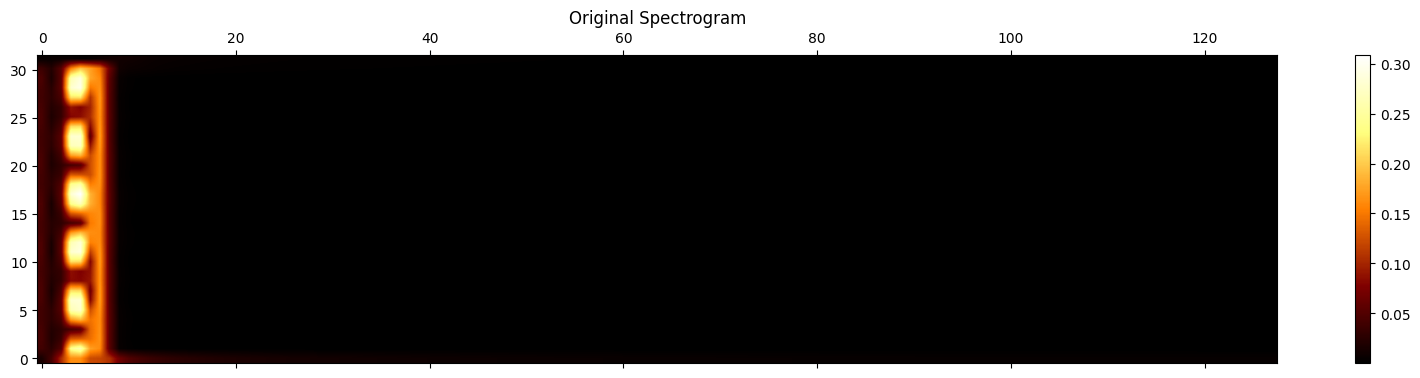

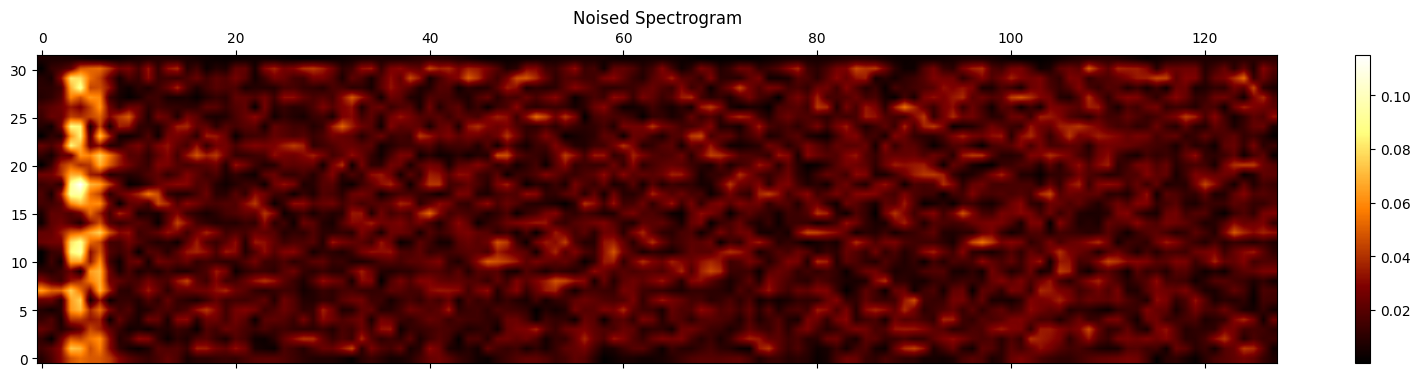

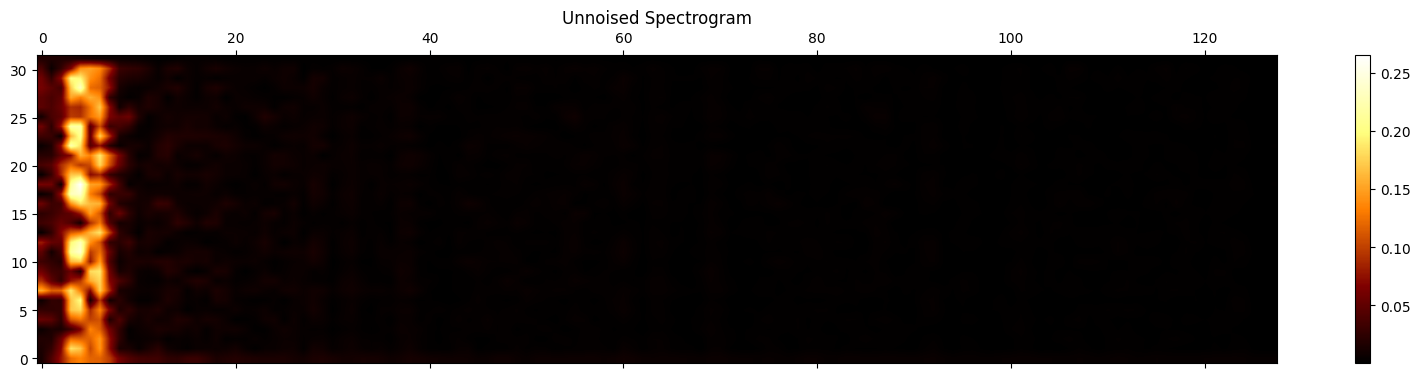

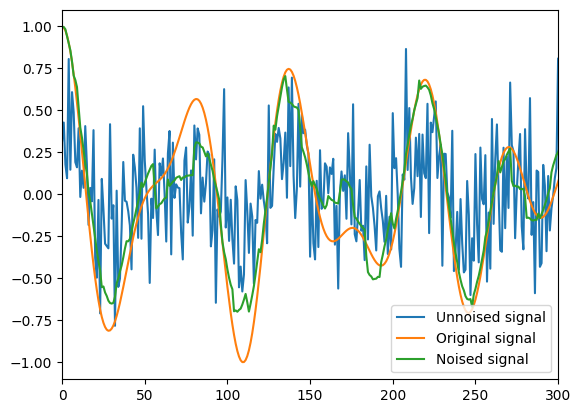

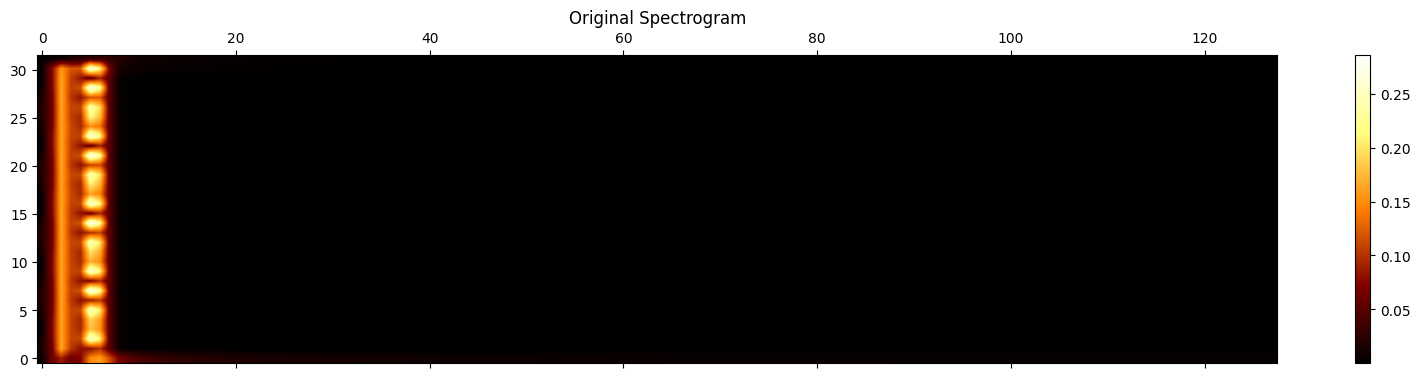

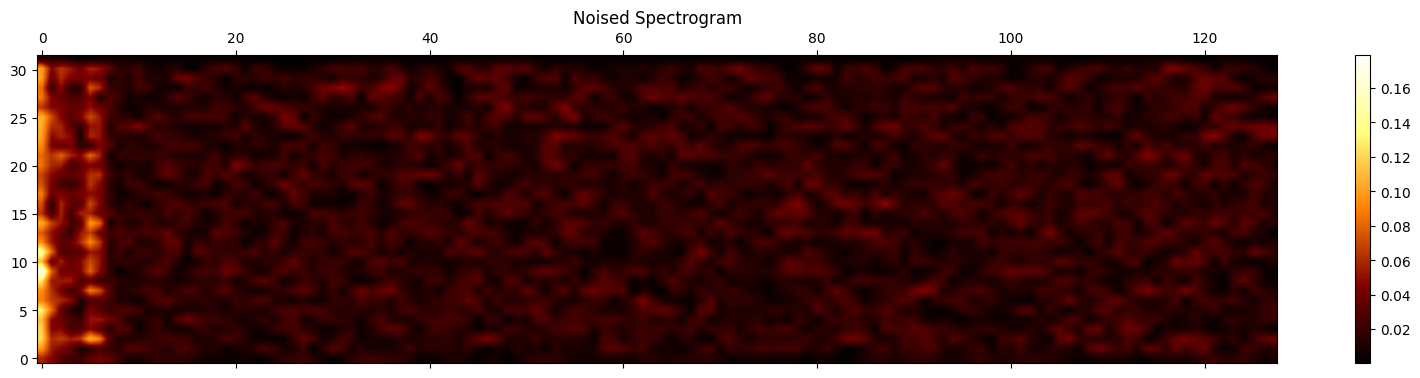

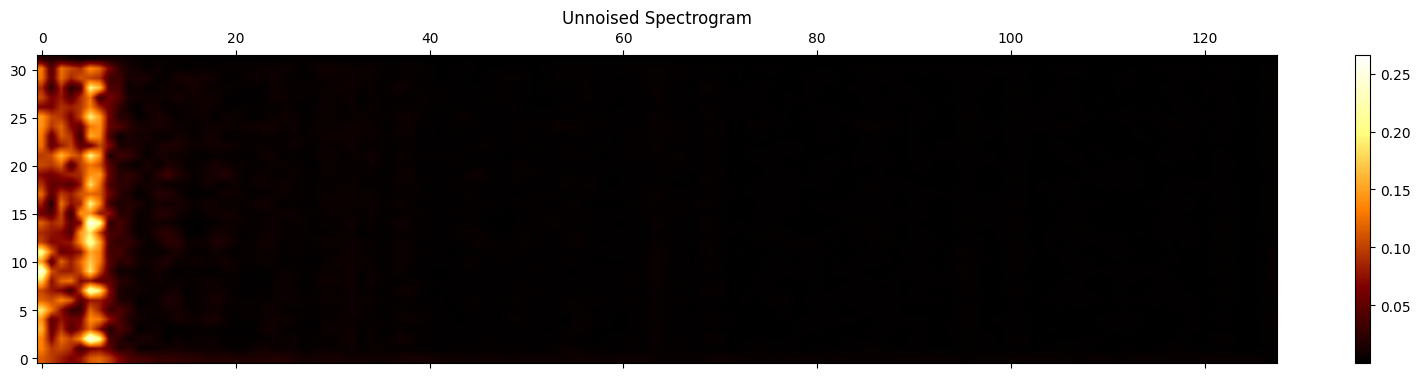

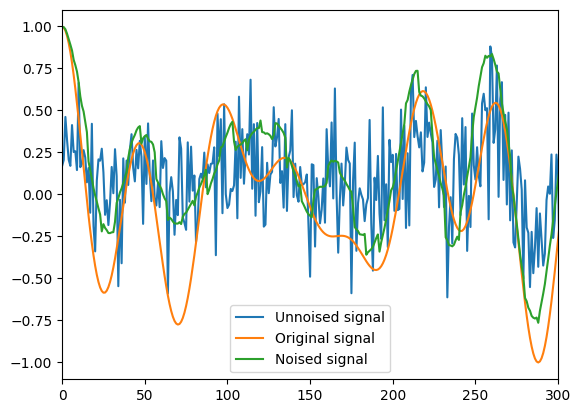

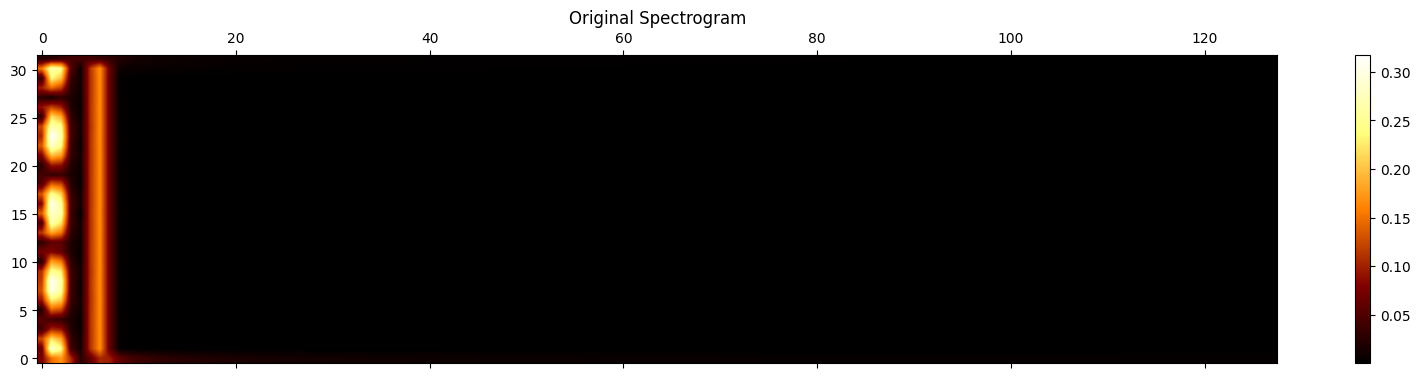

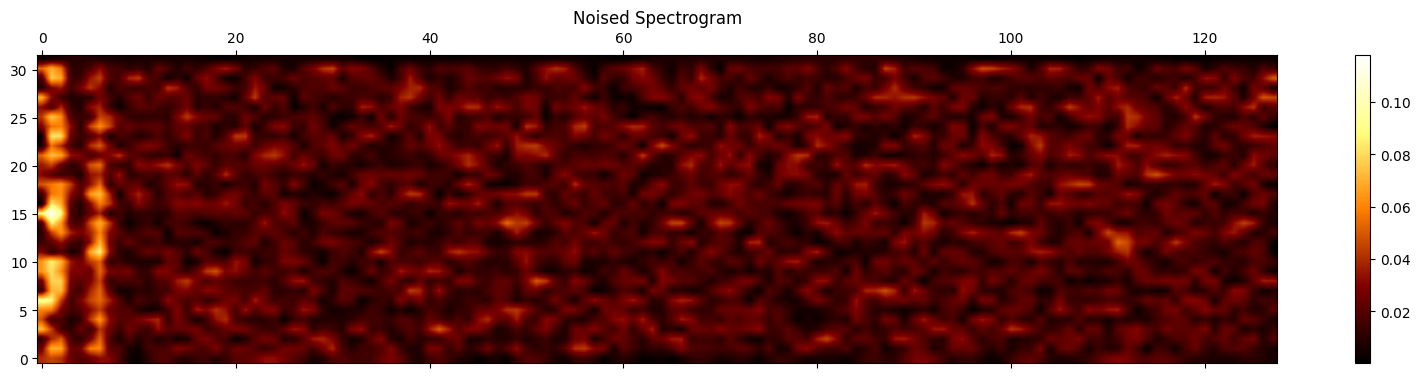

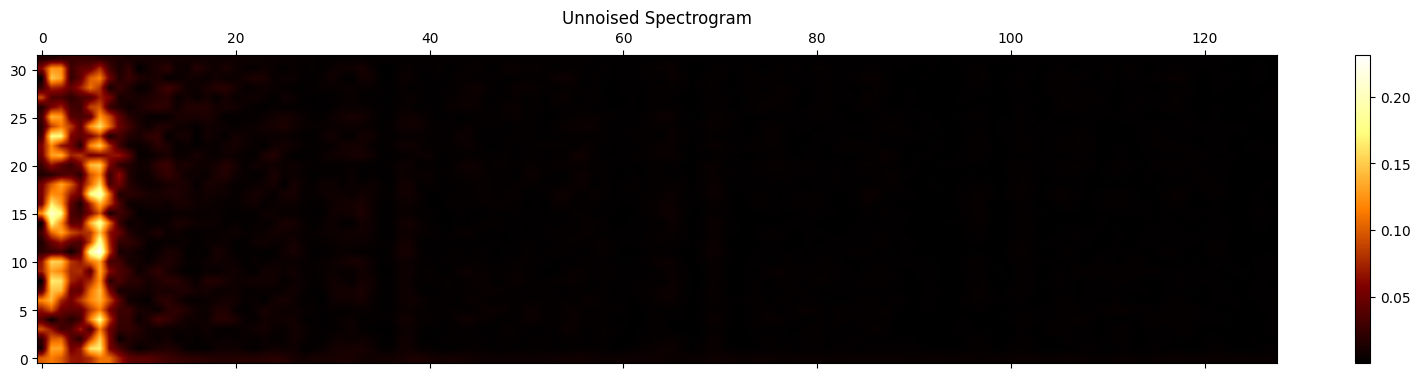

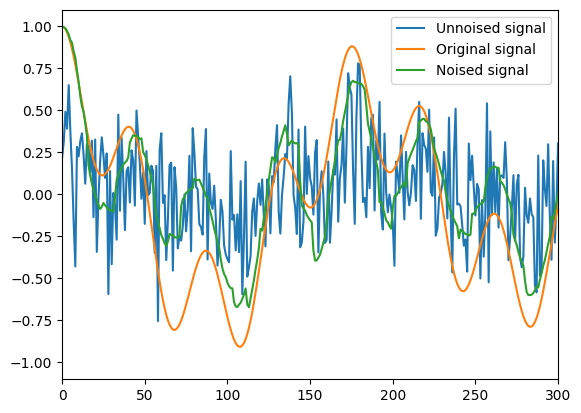

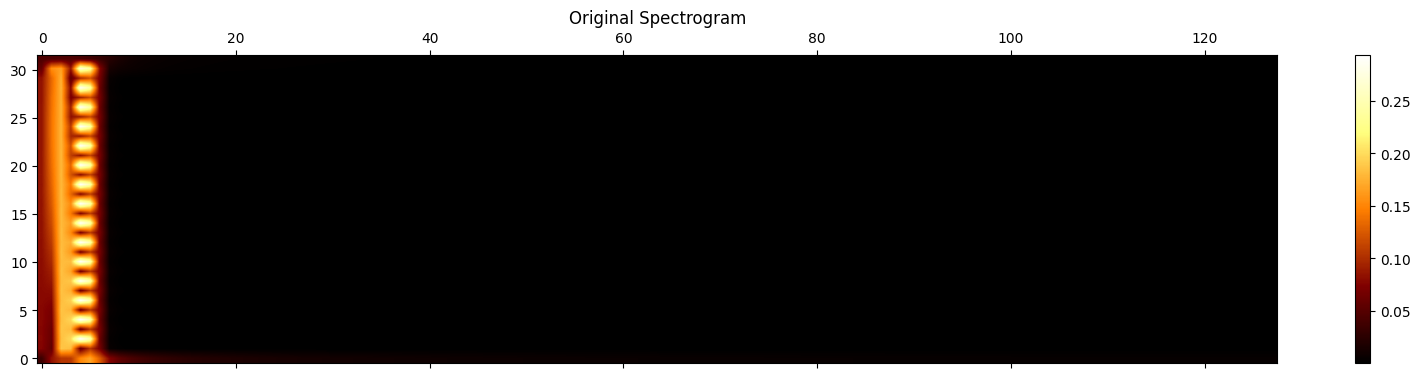

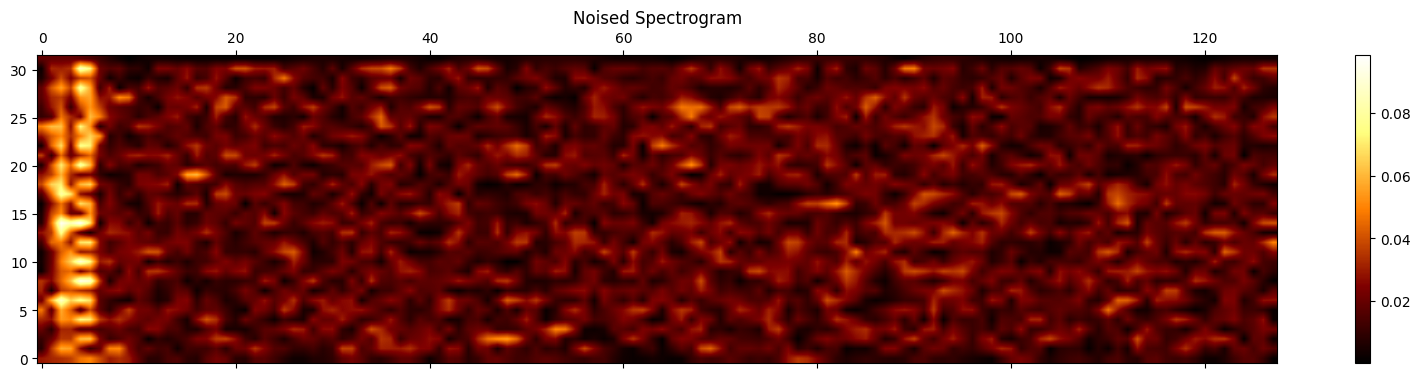

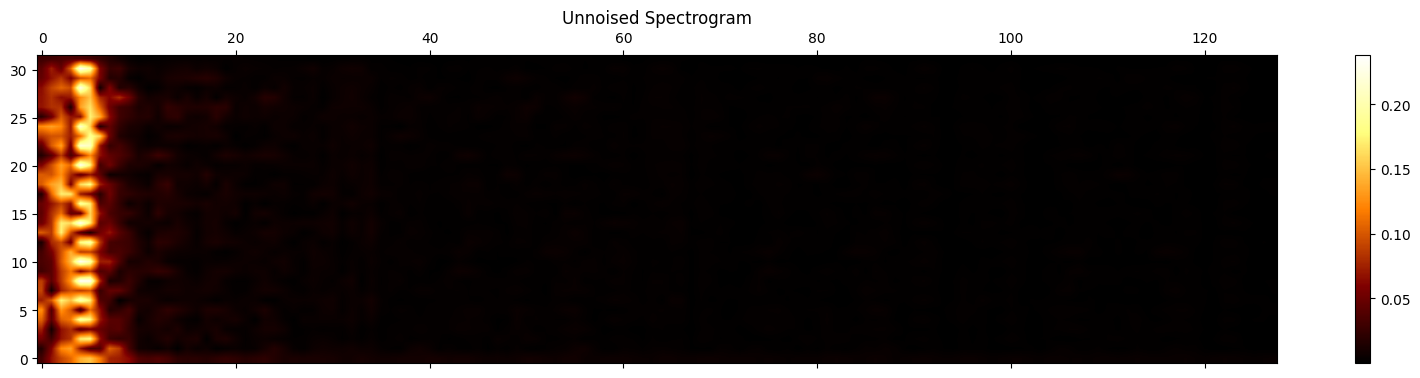

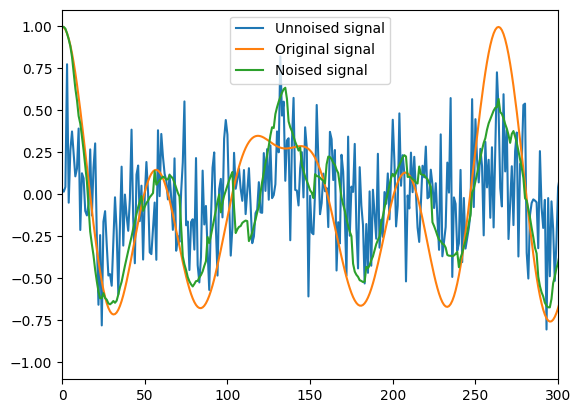

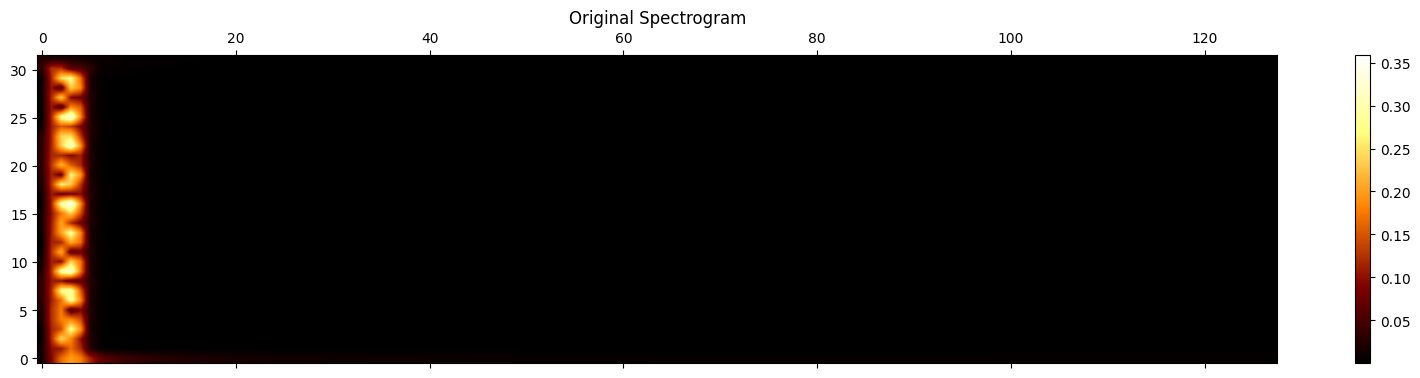

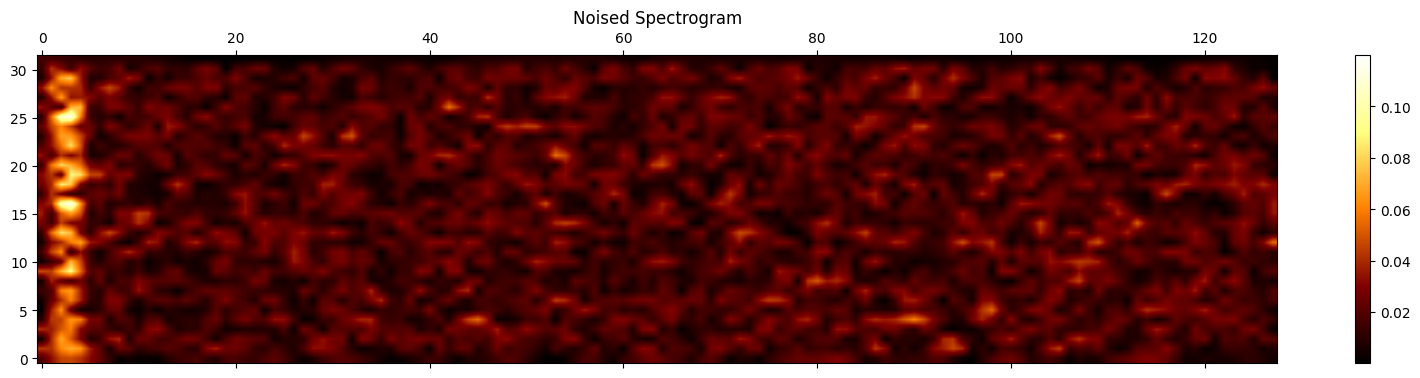

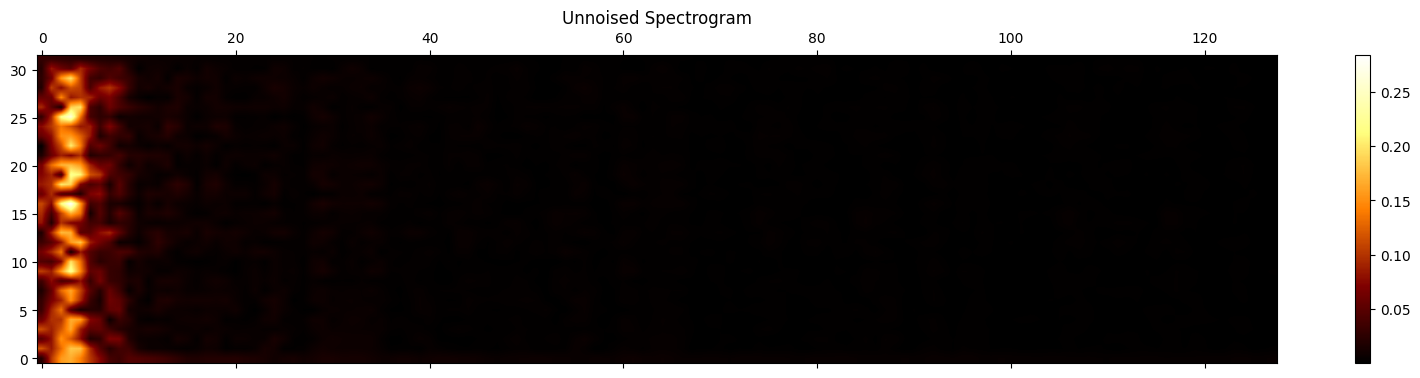

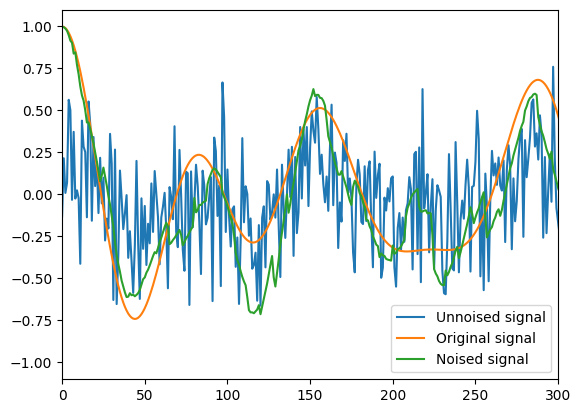

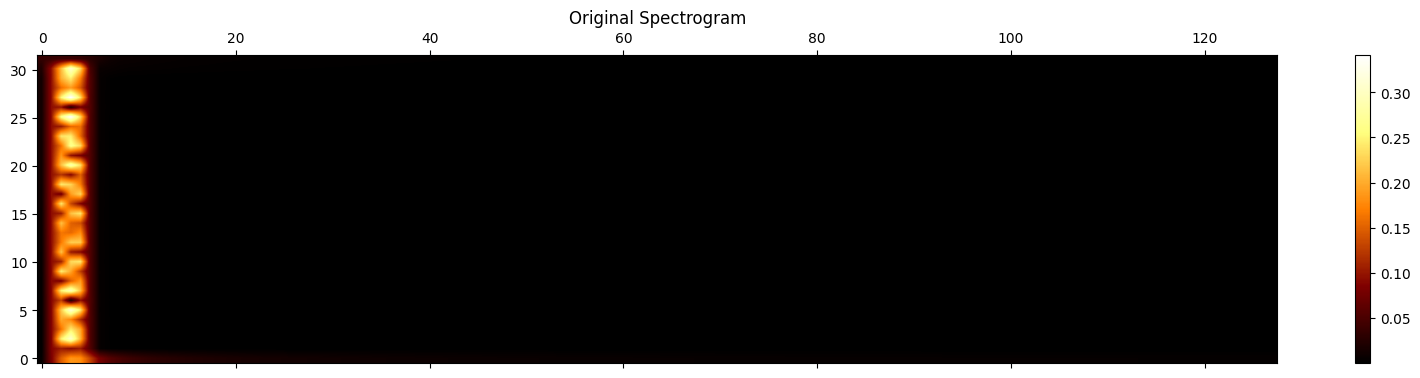

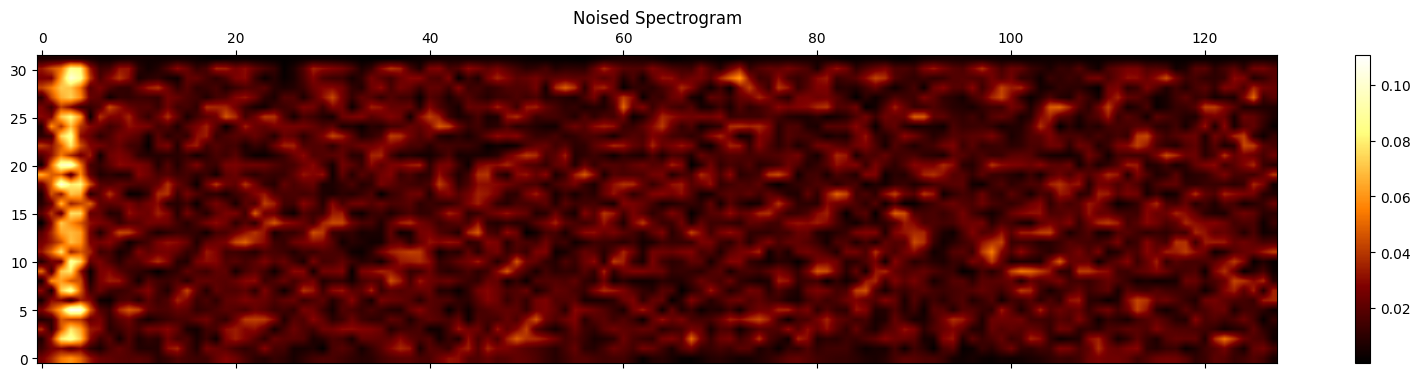

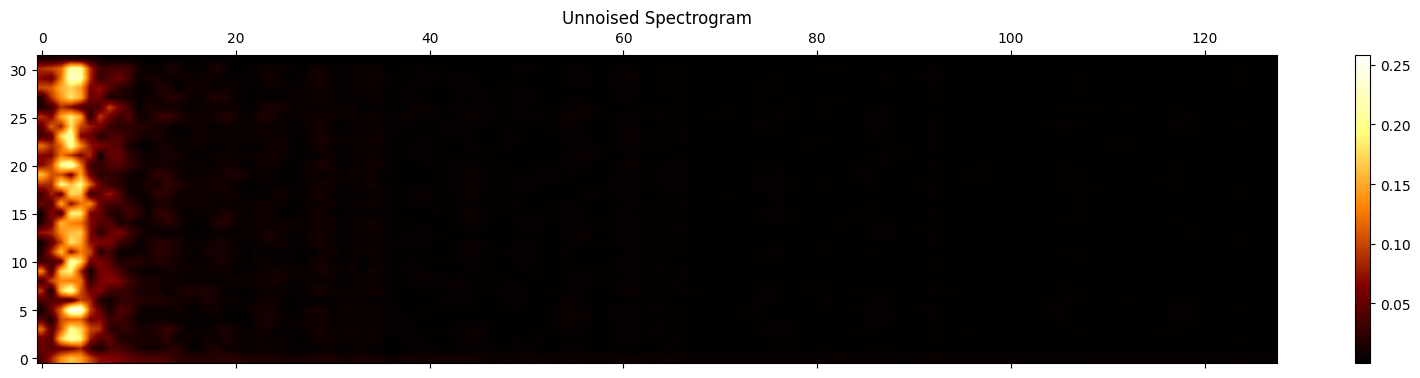

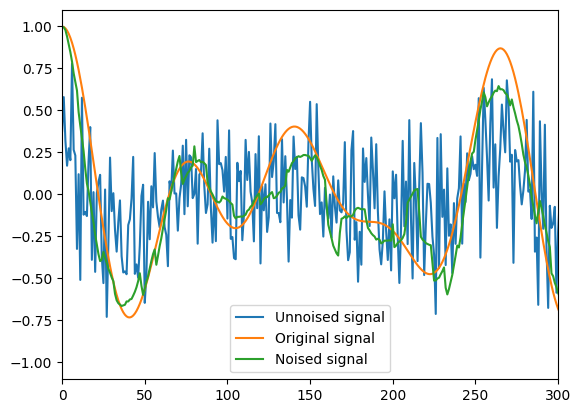

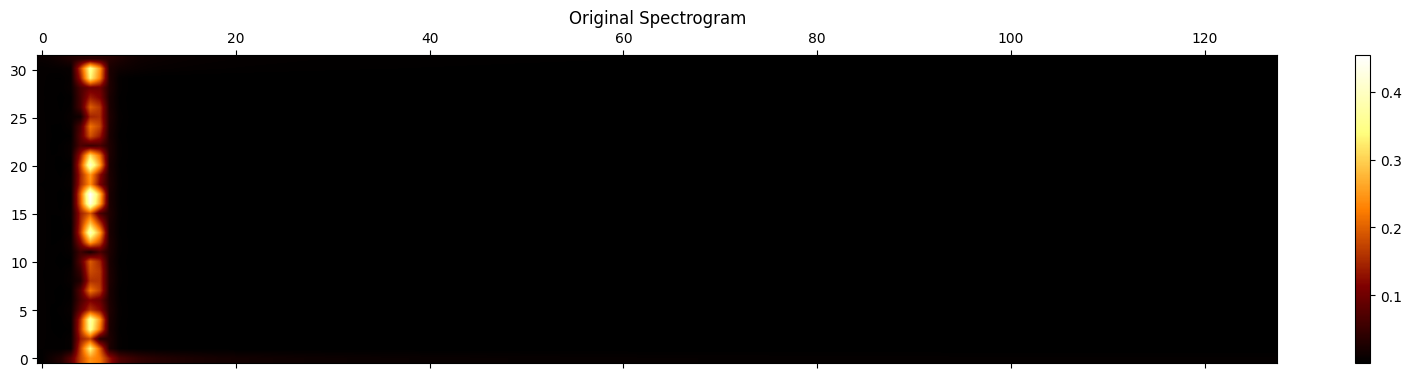

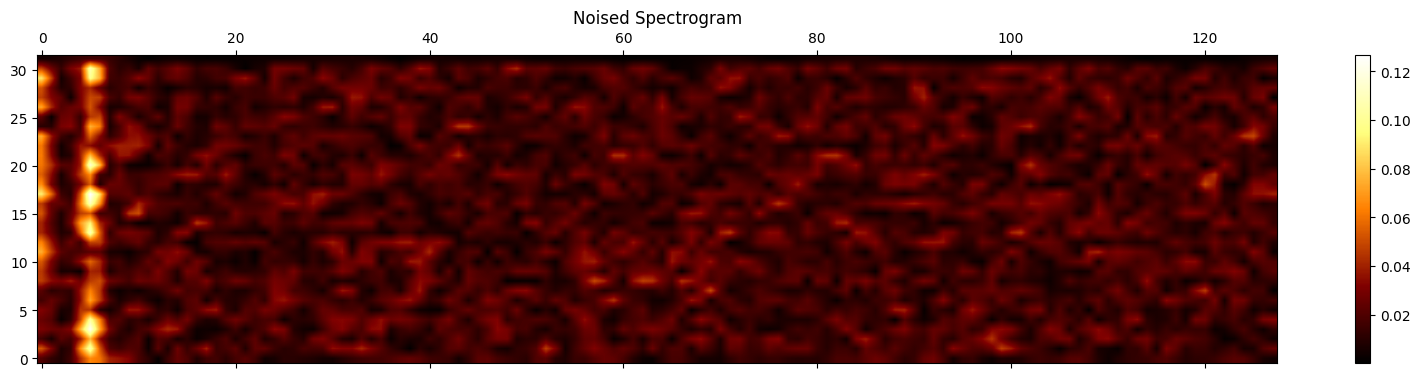

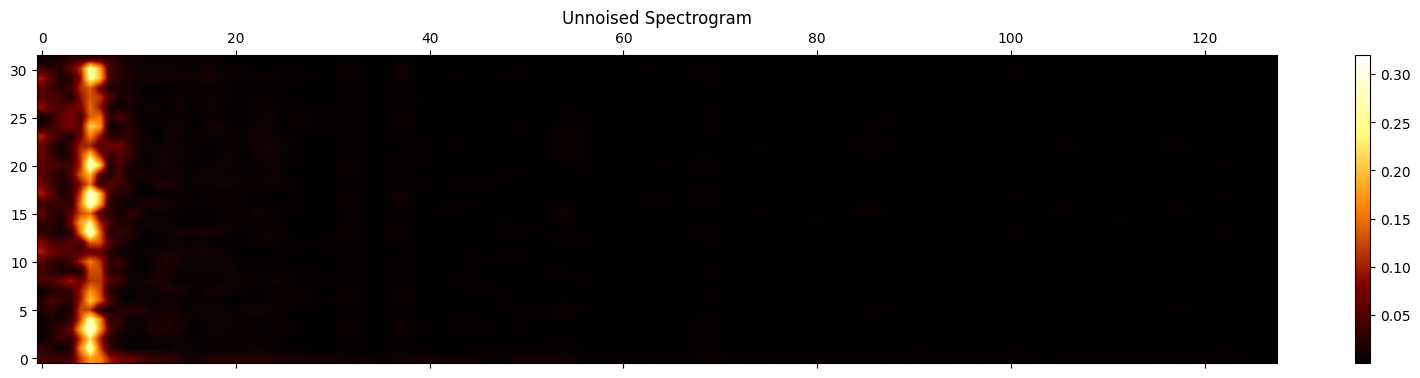

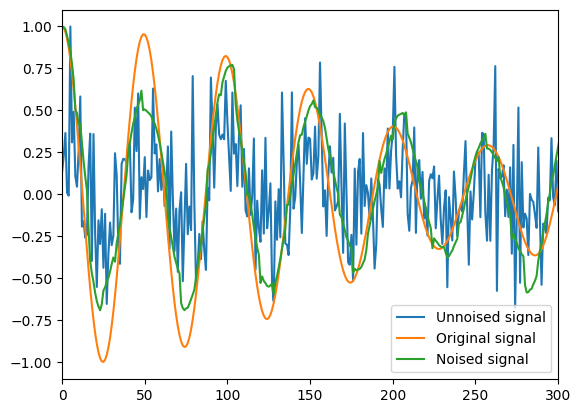

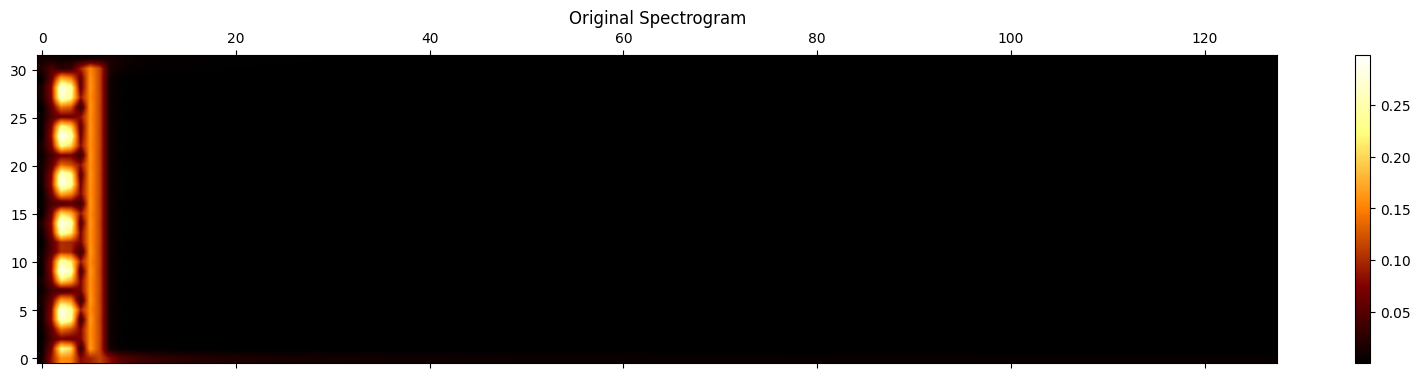

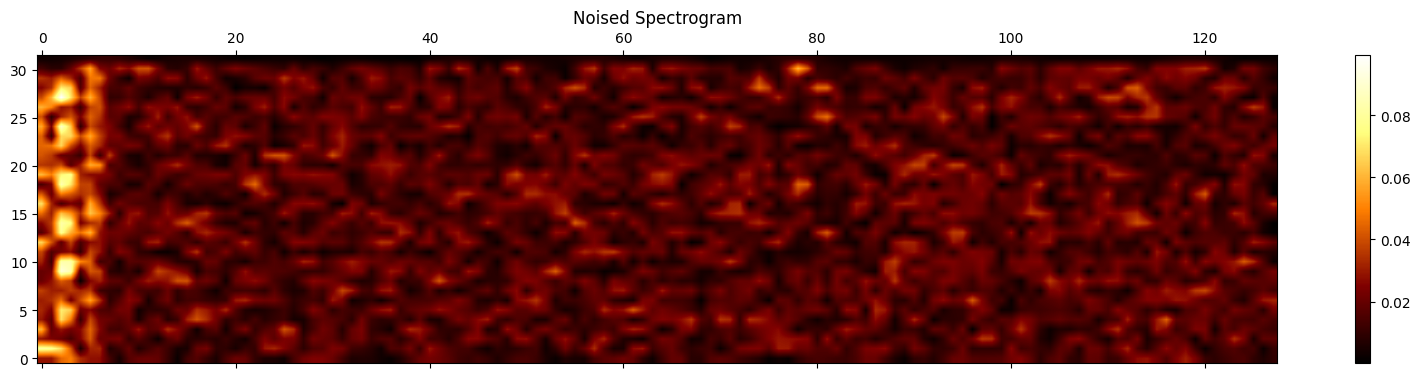

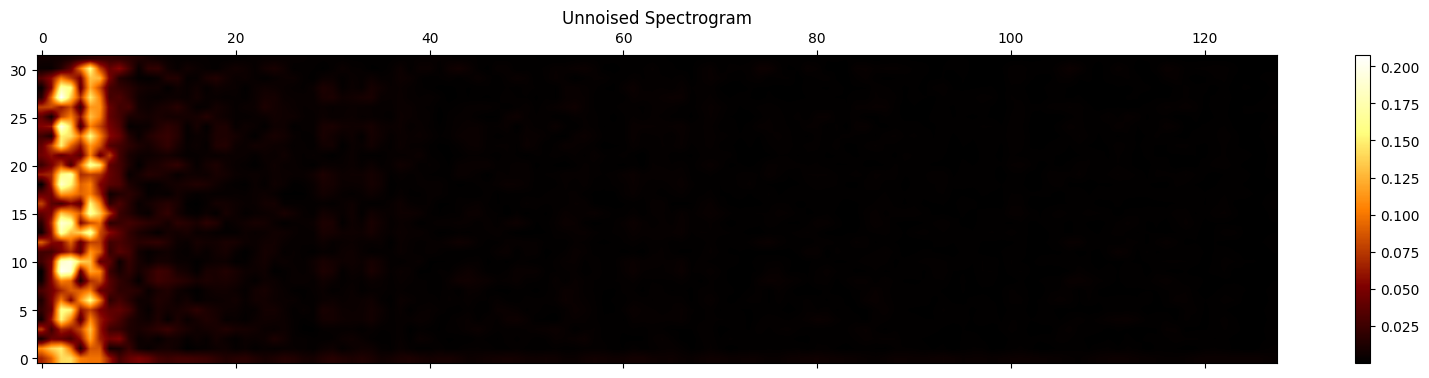

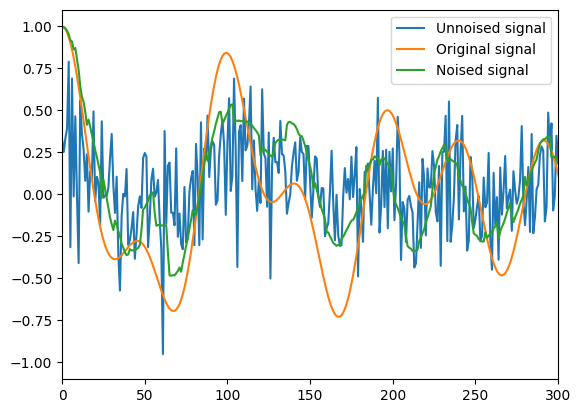

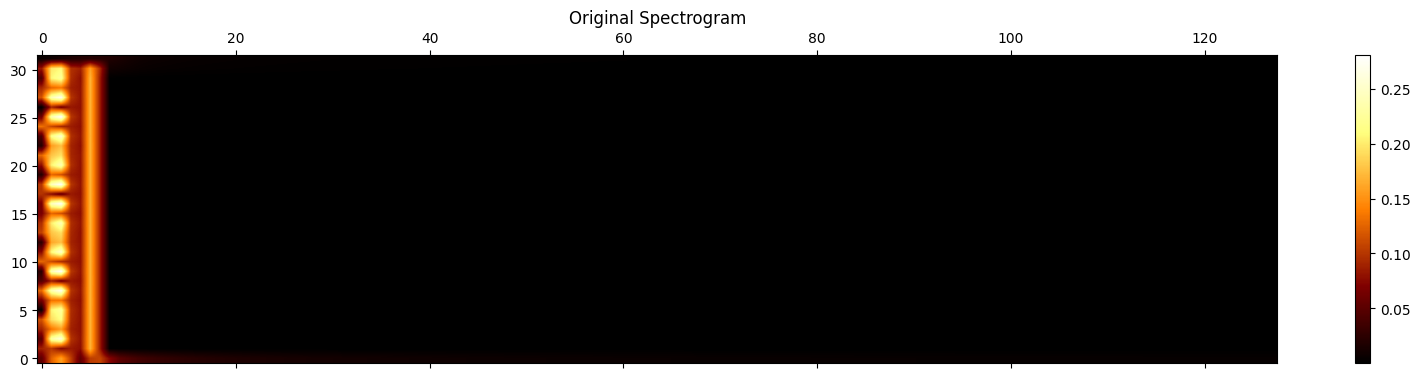

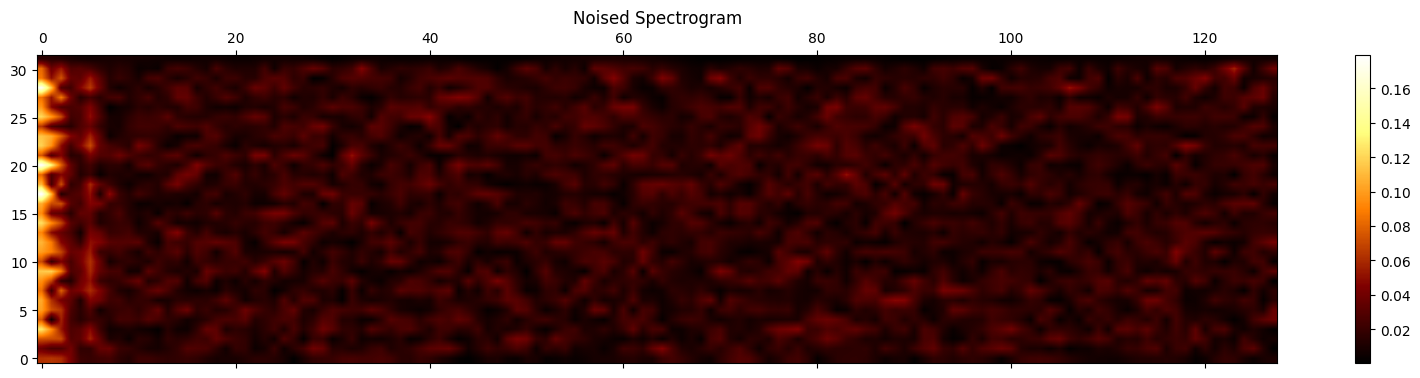

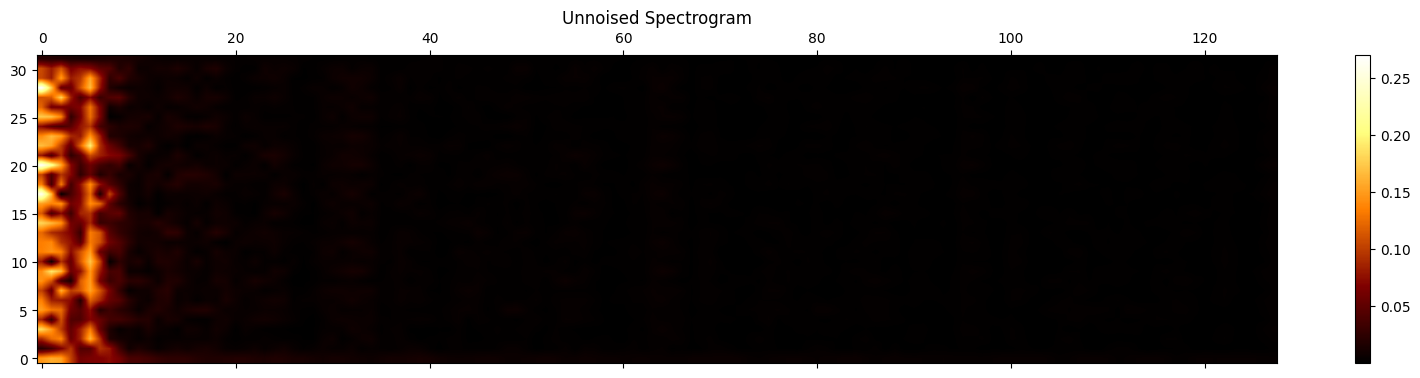

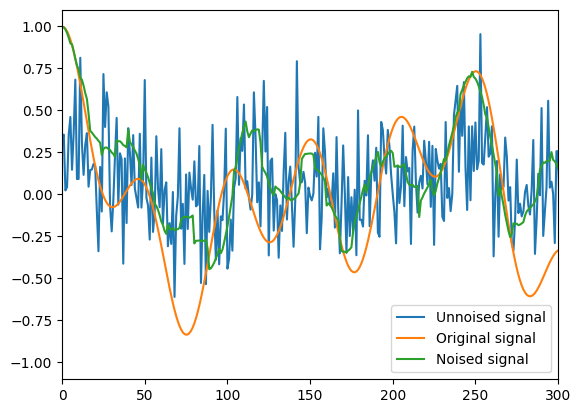

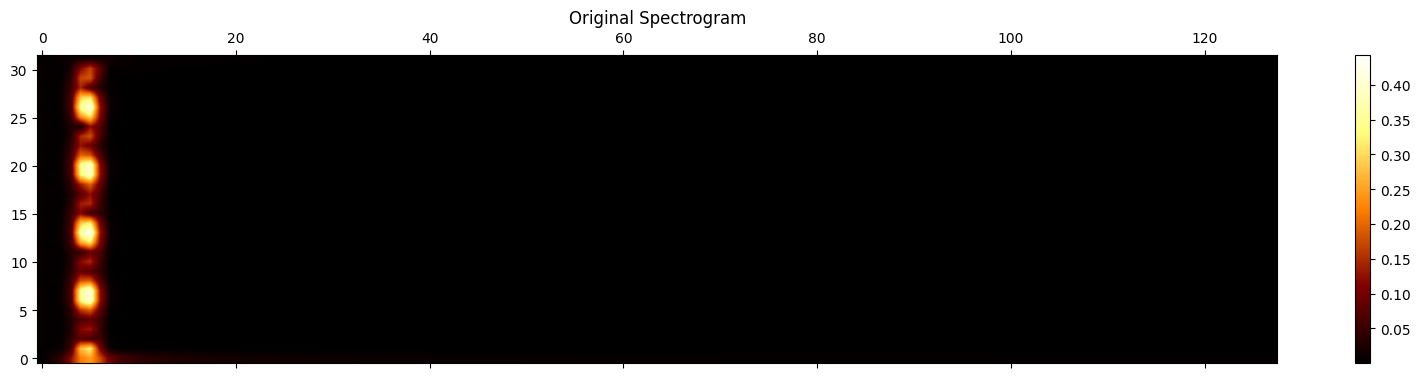

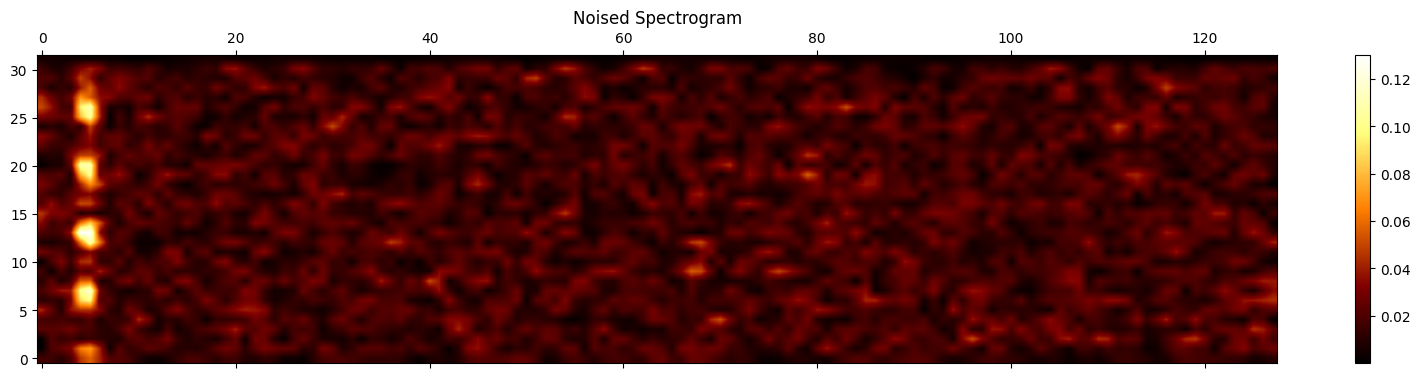

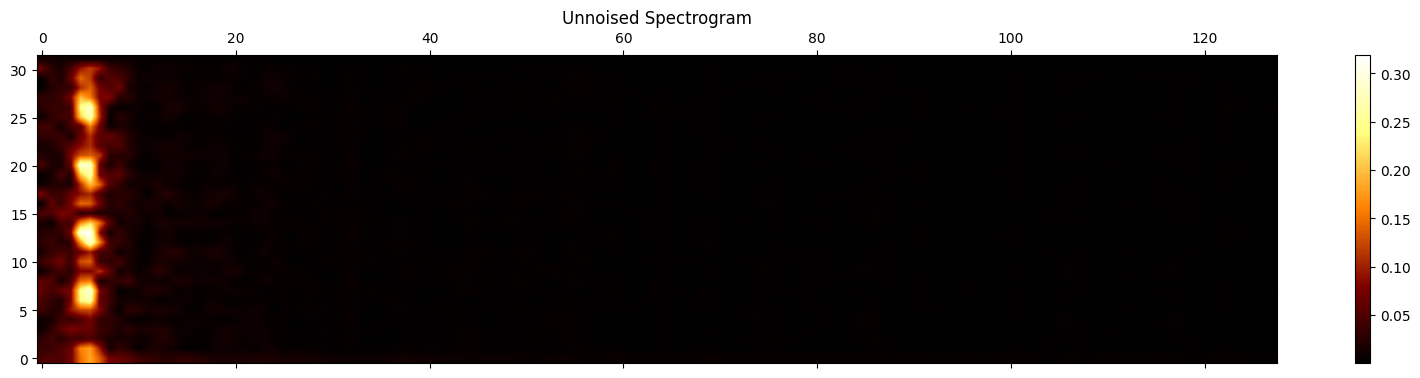

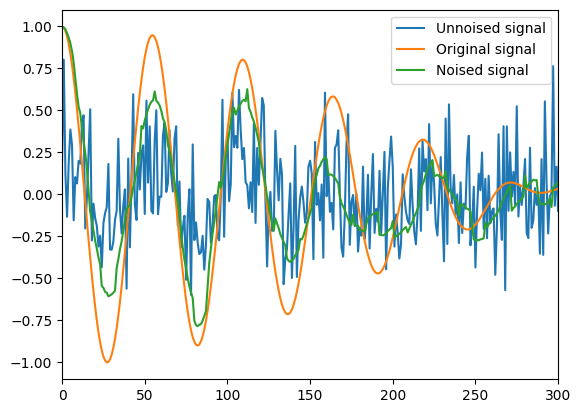

In [172]:
from scipy import signal

for clean, dirty in testloader:

    clean = clean.detach().cpu().numpy()
    clean = clean.reshape(-1,)

    dirty0 = dirty.detach().cpu().numpy()
    dirty0 = dirty0.reshape(-1,)

    dirty = dirty.to(device)
    dirty = model(dirty)
    dirty = dirty.detach().cpu().numpy()
    dirty = dirty.reshape(-1,)

    clean = clean*2-1
    dirty = dirty*2-1
    dirty0 = dirty0*2-1

    X = np.abs(signal.stft(clean, nperseg=254, noverlap=120)[2])

    Xorig = np.abs(signal.stft(dirty0, nperseg=254, noverlap=120)[2])

    Xres =  np.abs(signal.stft(dirty, nperseg=254, noverlap=120)[2])

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(X), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title('Original Spectrogram')

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(Xorig), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title('Noised Spectrogram')

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(Xres), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title('Unnoised Spectrogram')

    plt.figure()
    plt.plot(np.arange(0, 4096, 1), dirty0, label='Unnoised signal')
    plt.plot(np.arange(0, 4096, 1), clean, label='Original signal')
    plt.plot(np.arange(0, 4096, 1), dirty, label='Noised signal')
    plt.legend()
    plt.xlim([0, 300])


In [173]:
PATH = "presentation/model3f.pth"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH